# Ba & Discharge relationship (Backup)

* This notebook is a collection of what I did in investgating the linear relation between Ba and discharge. But finally I found the relatioin is not the best answer for Barium forcing, so everything here is not used and I just save the code as a backup.

In [1]:
import sys
sys.path.insert(0, '_libs/')
import NEMO_tools as Nts
from Mat2Py import datenum2datetime, datetime2datenum 

In [2]:
import glob
import scipy.io
import datetime
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import cm
% matplotlib inline

In [3]:
def mutifig6(SIZE=(16, 12)):
    fig=plt.figure(figsize=SIZE)
    plt.subplots_adjust(hspace = 0.5)
    ax1=plt.subplot2grid((6, 1), (0, 0), colspan=6, rowspan=1)
    ax2=plt.subplot2grid((6, 1), (1, 0), colspan=6, rowspan=1)
    ax3=plt.subplot2grid((6, 1), (2, 0), colspan=6, rowspan=1)
    ax4=plt.subplot2grid((6, 1), (3, 0), colspan=6, rowspan=1)
    ax5=plt.subplot2grid((6, 1), (4, 0), colspan=6, rowspan=1)
    ax6=plt.subplot2grid((6, 1), (5, 0), colspan=6, rowspan=1)
    return ax1, ax2, ax3, ax4, ax5, ax6

In [4]:
def daily2monmean(dt, data):
    '''
    =======================================================================
    Convert data in days to monthly mean series
                            ----- created on 2014/12/25, Yingkai (Kyle) Sha
    -----------------------------------------------------------------------
        data_dt, series, bin_count = daily2monmean(...)
    -----------------------------------------------------------------------
    Input:
            dt: A list of original data's datetime.datetime objects
            data: original data
    Output:
            data_dt: A list of monmean datetime.datetime objects
            data: monmean data
            bin_count: how many points fall into each months, 
                        data[i]=np.nan when bin_count[i]=0.
    ======================================================================= 
    '''
    import datetime
    import numpy as np
    from dateutil.relativedelta import relativedelta
    
    dt=sorted(dt) # increase order
    # Calculate the length of series
    L=(dt[-1].year-dt[0].year+1)*12
    series=np.zeros(L)
    bin_count=np.zeros(L)
    # Bin data points
    for i in range(len(dt)):
        hit=(dt[i].year-dt[0].year)*12+dt[i].month
        series[hit-1] += data[i] # "-1" because it is Python
        bin_count[hit-1] += 1 # count    
    for i in range(L):
        if bin_count[i] > 0:
            series[i]=series[i]/bin_count[i]
        if bin_count[i] == 0:
            series[i]=np.nan            
    # generate a corresponding datetime series
    data_dt=[datetime.datetime(dt[0].year, 01, 01)]
    step=relativedelta(months=1)    
    for i in range(L-1): # don't know why but it needs L-1, or the size will missmatch
        temp=data_dt[i]
        temp += step
        data_dt.append(temp)
    
    return data_dt, series, bin_count

In [5]:
def seasonal_character(dt, data):
    '''
    =======================================================================
    bin daily data into 12 months
                            ----- created on 2014/12/25, Yingkai (Kyle) Sha
    -----------------------------------------------------------------------
        series, bin_count = seasonal_character(...)
    -----------------------------------------------------------------------
    Input:
            dt: A list of original data's datetime.datetime objects
            data: original data
    Output:
            data: data in 12 months
            bin_count: how many points fall into each months, 
                        data[i]=np.nan when bin_count[i]=0.
    ======================================================================= 
    '''
    #import datetime
    import numpy as np
    #from dateutil.relativedelta import relativedelta
    
    dt=sorted(dt) # increase order
    series=np.zeros(12)
    bin_count=np.zeros(12)
    # Bin data points
    for i in range(len(dt)):
        hit=dt[i].month
        series[hit-1] += data[i] # "-1" because it is Python
        bin_count[hit-1] += 1 # count    
    for i in range(12):
        if bin_count[i] > 0:
            series[i]=series[i]/bin_count[i]
        if bin_count[i] == 0:
            series[i]=np.nan        
    return series, bin_count

# River discharge records

Stations of discharge records.

Red means **agree** with Ba records, and these 3 rivers show a good relation between Ba and discharge.


<table align="left">
<tr>
<th>River</th>
<th>Station</th>
<th>Longitude</th>
<th>Latitude</th>
</tr>
<tr>
<td>Lena</td>
<td>Kusur</td>
<td>127.39 E</td>
<td>70.68 N</td>
</tr>
<tr>
<td>Kolyma</td>
<td>Kolymskoye</td>
<td>158.72 E</td>
<td>68.73 N</td>
</tr>
<tr>
<td>Yenisey</td>
<td>Igarka</td>
<td>86.48 E</td>
<td>67.43 N</td>
</tr>
<tr>
<td><font color="red">Mackenzie</font></td>
<td>Tsiigehtchic</td>
<td>133°45' W</td>
<td>67°26' N</td>
</tr>
<tr>
<td><font color="red">Ob'</font></td>
<td>Salekhard</td>
<td>66°36' E</td>
<td>66°31' N</td>
</tr>
<tr>
<td><font color="red">Yukon</font></td>
<td>Pilot Station</td>
<td>162°52' W</td>
<td>61°56' N</td>
</tr>
</table>

Stations of Ba records (also shown in section 2)
<table align="left">
<tr>
<th>River</th>
<th>Station</th>
<th>Longitude</th>
<th>Latitude</th>
</tr>
<tr>
<td>Lena</td>
<td>Zhigansk</td>
<td>123°22' E</td>
<td>66°46' N</td>
</tr>
<tr>
<td>Kolyma</td>
<td>Cherskiy</td>
<td>161°18' E</td>
<td>68°45' N</td>
</tr>
<tr>
<td>Yenisey</td>
<td>Dudinka</td>
<td>86°09' E</td>
<td>69°23' N</td>
</tr>
<tr>
<td>Mackenzie</td>
<td>Tsiigehtchic / Inuvik</td>
<td>133°45' W / 133°42' W</td>
<td>67°26' N / 68°20' N</td>
</tr>
<tr>
<td>Ob'</td>
<td>Salekhard</td>
<td>66°36' E</td>
<td>66°31' N</td>
</tr>
<tr>
<td>Yukon</td>
<td>Pilot Station</td>
<td>162°52' W</td>
<td>61°56' N</td>
</tr>
</table>

In [6]:
Le_discharge_name=glob.glob('_data/Samples/River Discharge/RussiaRivers/*Lena*.mat')
print("found file: \n{}".format(Le_discharge_name))
Le_discharge_obj=scipy.io.loadmat(Le_discharge_name[0])

Ob_discharge_name=glob.glob('_data/Samples/River Discharge/RussiaRivers/*Ob*.mat')
print("found file: \n{}".format(Ob_discharge_name))
Ob_discharge_obj=scipy.io.loadmat(Ob_discharge_name[0])

Ye_discharge_name=glob.glob('_data/Samples/River Discharge/RussiaRivers/*Yenisey*.mat')
print("found file: \n{}".format(Ye_discharge_name))
Ye_discharge_obj=scipy.io.loadmat(Ye_discharge_name[0])

Ko_discharge_name=glob.glob('_data/Samples/River Discharge/RussiaRivers/*Kolyma*.mat')
print("found file: \n{}".format(Ko_discharge_name))
Ko_discharge_obj=scipy.io.loadmat(Ko_discharge_name[0])

Ma_discharge_name=glob.glob('_data/Samples/River Discharge/Mackenzie/*Mackenzie*.mat')
print("found file: \n{}".format(Ma_discharge_name))
Ma_discharge_obj=scipy.io.loadmat(Ma_discharge_name[0])

Yu_discharge_name=glob.glob('_data/Samples/River Discharge/Yukon/*Yukon*.mat')
print("found file: \n{}".format(Yu_discharge_name))
Yu_discharge_obj=scipy.io.loadmat(Yu_discharge_name[0])

found file: 
['_data/Samples/River Discharge/RussiaRivers\\Temp_Lena.mat']
found file: 
['_data/Samples/River Discharge/RussiaRivers\\Temp_Ob.mat']
found file: 
['_data/Samples/River Discharge/RussiaRivers\\Temp_Yenisey.mat']
found file: 
['_data/Samples/River Discharge/RussiaRivers\\Temp_Kolyma.mat']
found file: 
['_data/Samples/River Discharge/Mackenzie\\Temp_Mackenzie.mat']
found file: 
['_data/Samples/River Discharge/Yukon\\Temp_Yukon.mat']


## Monthly mean discharge

In [10]:
PARTNERS_name=glob.glob('../../Arctic-obs/MATLAB files/River_PATRNERS_Ba.mat')
PARTNERS_obj=scipy.io.loadmat(PARTNERS_name[0])
PARTNERS_Lena=PARTNERS_obj['Lena']
PARTNERS_Kolyma=PARTNERS_obj['Kolyma']
PARTNERS_Yenisey=PARTNERS_obj['Yenisey']
PARTNERS_Mackenzie=PARTNERS_obj['Mackenzie']
PARTNERS_Ob=PARTNERS_obj['Ob']
PARTNERS_Yukon=PARTNERS_obj['Yukon']

AGRO_name=glob.glob('../../Arctic-obs/MATLAB files/River_AGRO_Ba.mat')
AGRO_obj=scipy.io.loadmat(AGRO_name[0])
AGRO_Lena=AGRO_obj['Lena']
AGRO_Kolyma=AGRO_obj['Kolyma']
AGRO_Yenisey=AGRO_obj['Yenisey']
AGRO_Mackenzie=AGRO_obj['Mackenzie']
AGRO_Ob=AGRO_obj['Ob']
AGRO_Yukon=AGRO_obj['Yukon']

In [11]:
Lena_time=datenum2datetime(PARTNERS_Lena[:, 0]) + datenum2datetime(AGRO_Lena[:, 0])
Kolyma_time=datenum2datetime(PARTNERS_Kolyma[:, 0]) + datenum2datetime(AGRO_Kolyma[:, 0])
Yenisey_time=datenum2datetime(PARTNERS_Yenisey[:, 0]) + datenum2datetime(AGRO_Yenisey[:, 0])
Mackenzie_time=datenum2datetime(PARTNERS_Mackenzie[:, 0]) + datenum2datetime(AGRO_Mackenzie[:, 0])
Ob_time=datenum2datetime(PARTNERS_Ob[:, 0]) + datenum2datetime(AGRO_Ob[:, 0])
Yukon_time=datenum2datetime(PARTNERS_Yukon[:, 0]) + datenum2datetime(AGRO_Yukon[:, 0])

In [12]:
Lena_Ba=np.hstack((PARTNERS_Lena[:, 1], AGRO_Lena[:, 1]))
Kolyma_Ba=np.hstack((PARTNERS_Kolyma[:, 1], AGRO_Kolyma[:, 1]))
Yenisey_Ba=np.hstack((PARTNERS_Yenisey[:, 1], AGRO_Yenisey[:, 1]))
Mackenzie_Ba=np.hstack((PARTNERS_Mackenzie[:, 1], AGRO_Mackenzie[:, 1]))
Ob_Ba=np.hstack((PARTNERS_Ob[:, 1], AGRO_Ob[:, 1]))
Yukon_Ba=np.hstack((PARTNERS_Yukon[:, 1], AGRO_Yukon[:, 1]))

In [13]:
Lena_monmean, Lena_Ba_monmean, Lena_bin = daily2monmean(Lena_time, Lena_Ba)
Kolyma_monmean, Kolyma_Ba_monmean, Kolyma_bin = daily2monmean(Kolyma_time, Kolyma_Ba)
Yenisey_monmean, Yenisey_Ba_monmean, Yenisey_bin = daily2monmean(Yenisey_time, Yenisey_Ba)
Mackenzie_monmean, Mackenzie_Ba_monmean, Mackenzie_bin = daily2monmean(Mackenzie_time, Mackenzie_Ba)
Ob_monmean, Ob_Ba_monmean, Ob_bin = daily2monmean(Ob_time, Ob_Ba)
Yukon_monmean, Yukon_Ba_monmean, Yukon_bin = daily2monmean(Yukon_time, Yukon_Ba)

In [14]:
original_time=Le_discharge_obj['time_Lena'][:]
time_Lena=datenum2datetime(original_time.flatten())
Lena_discharge=Le_discharge_obj['Lena_discharge_daily'][:]
Lena_discharge_full=Le_discharge_obj['Lena_discharge_full'][:]
date_full = [Lena_monmean[0] + datetime.timedelta(days=x) for x in range(0, (Lena_monmean[-1]-Lena_monmean[0]).days)]
Lena_monmean, Lena_discharge_monmean, _=daily2monmean(date_full, Lena_discharge_full)

original_time=Ob_discharge_obj['time_Ob'][:]
time_Ob=datenum2datetime(original_time.flatten())
Ob_discharge=Ob_discharge_obj['Ob_discharge_daily'][:]
Ob_discharge_full=Ob_discharge_obj['Ob_discharge_full'][:]
date_full = [Ob_monmean[0] + datetime.timedelta(days=x) for x in range(0, (Ob_monmean[-1]-Ob_monmean[0]).days)]
Ob_monmean, Ob_discharge_monmean, _=daily2monmean(date_full, Ob_discharge_full)

original_time=Ye_discharge_obj['time_Yenisey'][:]
time_Yenisey=datenum2datetime(original_time.flatten())
Yenisey_discharge=Ye_discharge_obj['Yenisey_discharge_daily'][:]
Yenisey_discharge_full=Ye_discharge_obj['Yenisey_discharge_full'][:]
date_full = [Yenisey_monmean[0] + datetime.timedelta(days=x) for x in range(0, (Yenisey_monmean[-1]-Yenisey_monmean[0]).days)]
Yenisey_monmean, Yenisey_discharge_monmean, _=daily2monmean(date_full, Yenisey_discharge_full)

original_time=Ko_discharge_obj['time_Kolyma'][:]
time_Kolyma=datenum2datetime(original_time.flatten())
Kolyma_discharge=Ko_discharge_obj['Kolyma_discharge_daily'][:]
Kolyma_discharge_full=Ko_discharge_obj['Kolyma_discharge_full'][:]
date_full = [Kolyma_monmean[0] + datetime.timedelta(days=x) for x in range(0, (Kolyma_monmean[-1]-Kolyma_monmean[0]).days)]
Kolyma_monmean, Kolyma_discharge_monmean, _=daily2monmean(date_full, Kolyma_discharge_full)

original_time=Ma_discharge_obj['time_Mackenzie'][:]
time_Mackenzie=datenum2datetime(original_time.flatten())
Mackenzie_discharge=Ma_discharge_obj['Mackenzie_discharge_daily'][:]
Mackenzie_discharge_monmean=Ma_discharge_obj['Mackenzie_discharge_monmean'][:]

original_time=Yu_discharge_obj['time_Yukon'][:]
time_Yukon=datenum2datetime(original_time.flatten())
Yukon_discharge=Yu_discharge_obj['Yukon_discharge_daily'][:]
Yukon_discharge_full=Yu_discharge_obj['Yukon_discharge_full'][:]
date_full = [Yukon_monmean[0] + datetime.timedelta(days=x) for x in range(0, (Yukon_monmean[-1]-Yukon_monmean[0]).days)]
Yukon_monmean, Yukon_discharge_monmean, _=daily2monmean(date_full, Yukon_discharge_full)

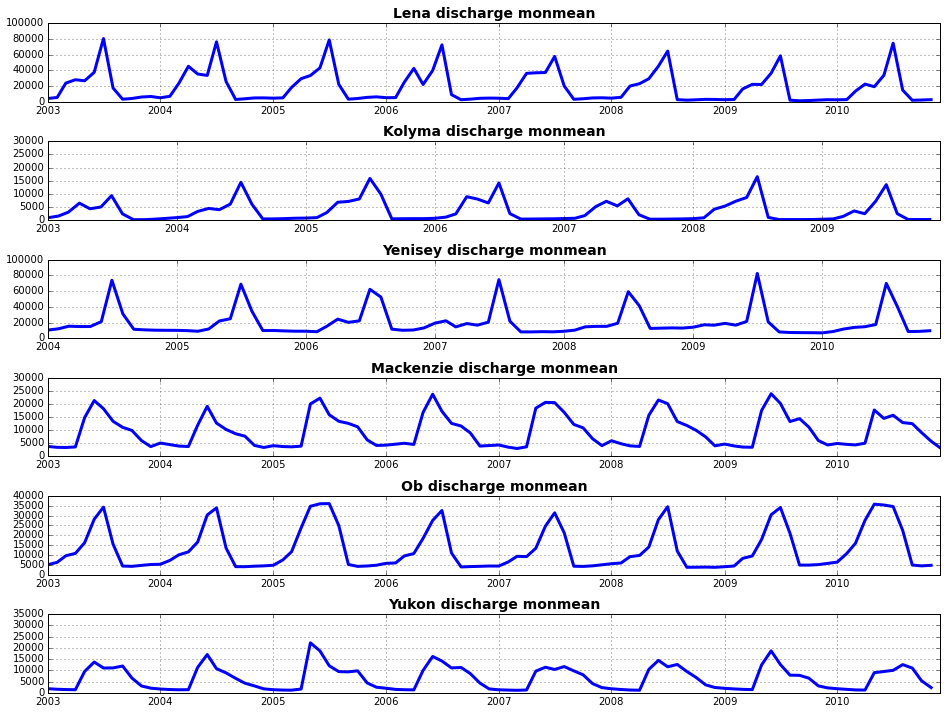

In [16]:
ax1, ax2, ax3, ax4, ax5, ax6 = mutifig6()
#
ax1.plot(Lena_monmean, Lena_discharge_monmean, linewidth=3)
ax1.set_xlim(Lena_monmean[0], Lena_monmean[-1]); ax1.set_ylim(0, 100000)
ax1.set_title('Lena discharge monmean', fontsize=14, fontweight='bold')
ax1.grid()
#
ax2.plot(Kolyma_monmean, Kolyma_discharge_monmean, linewidth=3)
ax2.set_xlim(Kolyma_monmean[0], Kolyma_monmean[-1]); ax2.set_ylim(0, 30000)
ax2.set_title('Kolyma discharge monmean', fontsize=14, fontweight='bold')
ax2.grid()
#
ax3.plot(Yenisey_monmean, Yenisey_discharge_monmean, linewidth=3)
ax3.set_xlim(Yenisey_monmean[0], Yenisey_monmean[-1])
ax3.set_ylim(0, 100000)
ax3.set_title('Yenisey discharge monmean', fontsize=14, fontweight='bold')
ax3.grid()

ax4.plot(Mackenzie_monmean, Mackenzie_discharge_monmean, linewidth=3)
ax4.set_xlim(Mackenzie_monmean[0], Mackenzie_monmean[-1])
ax4.set_ylim(0, 30000)
ax4.set_title('Mackenzie discharge monmean', fontsize=14, fontweight='bold')
ax4.grid()

ax5.plot(Ob_monmean, Ob_discharge_monmean, linewidth=3)
ax5.set_xlim(Ob_monmean[0], Ob_monmean[-1])
ax5.set_ylim(0, 40000)
ax5.set_title('Ob discharge monmean', fontsize=14, fontweight='bold')
ax5.grid()

ax6.plot(Yukon_monmean, Yukon_discharge_monmean, linewidth=3)
ax6.set_xlim(Yukon_monmean[0], Yukon_monmean[-1])
ax6.set_ylim(0, 35000)
ax6.set_title('Yukon discharge monmean', fontsize=14, fontweight='bold')
ax6.grid()

# Ba v.s. Discharge

In [17]:
MAT = scipy.io.loadmat('_data/Exchange/Ba_vs_Riverflow.mat')
monmean = datenum2datetime(np.squeeze(MAT['monmean_time']))
Lena_Ba = MAT['Lena_Ba'][:]; Lena_time = datenum2datetime(np.squeeze(MAT['Lena_time'])); 
Lena_discharge = MAT['Lena_discharge'][:]; Lena_discharge_monmean = MAT['Lena_discharge_monmean'][:]
Ob_Ba = MAT['Ob_Ba'][:]; Ob_time = datenum2datetime(np.squeeze(MAT['Ob_time'])); 
Ob_discharge = MAT['Ob_discharge'][:]; Ob_discharge_monmean = MAT['Ob_discharge_monmean'][:]
Kolyma_Ba = MAT['Kolyma_Ba'][:]; Kolyma_time = datenum2datetime(np.squeeze(MAT['Kolyma_time'])); 
Kolyma_discharge = MAT['Kolyma_discharge'][:]; Kolyma_discharge_monmean = MAT['Kolyma_discharge_monmean'][:]
Yenisey_Ba = MAT['Yenisey_Ba'][:]; Yenisey_time = datenum2datetime(np.squeeze(MAT['Yenisey_time'])); 
Yenisey_discharge = MAT['Yenisey_discharge'][:]; Yenisey_discharge_monmean = MAT['Yenisey_discharge_monmean'][:]
Mackenzie_Ba = MAT['Mackenzie_Ba'][:]; Mackenzie_time = datenum2datetime(np.squeeze(MAT['Mackenzie_time'])); 
Mackenzie_discharge = MAT['Mackenzie_discharge'][:]; Mackenzie_discharge_monmean = MAT['Mackenzie_discharge_monmean'][:]
Yukon_Ba = MAT['Yukon_Ba'][:]; Yukon_time = datenum2datetime(np.squeeze(MAT['Yukon_time'])); 
Yukon_discharge = MAT['Yukon_discharge'][:]; Yukon_discharge_monmean = MAT['Yukon_discharge_monmean'][:]

In [18]:
from scipy.stats.stats import pearsonr

In [19]:
total_Ba = np.array(list(Lena_Ba.flat) + list(Ob_Ba.flat) + list(Kolyma_Ba.flat) + list(Yenisey_Ba.flat) + \
                    list(Mackenzie_Ba.flat) + list(Yukon_Ba.flat))
total_discharge = np.array(list(Lena_discharge.flat) + list(Ob_discharge.flat) + list(Kolyma_discharge.flat) + \
                    list(Yenisey_discharge.flat) + list(Mackenzie_discharge.flat) + list(Yukon_discharge.flat))
russia_Ba = np.array(list(Lena_Ba.flat) + list(Ob_Ba.flat) + list(Kolyma_Ba.flat) + list(Yenisey_Ba.flat))
russia_discharge = np.array(list(Lena_discharge.flat) + list(Ob_discharge.flat) + list(Kolyma_discharge.flat) + \
                    list(Yenisey_discharge.flat))
corr, p = pearsonr(total_Ba, total_discharge)
print('Total\n\tNumber of data points: {}\n\tCorrelation Index: {}\n\tSignificance: {}'.format(len(total_Ba), corr, p))

Total
	Number of data points: 128
	Correlation Index: -0.252690750898
	Significance: 0.00400613446891


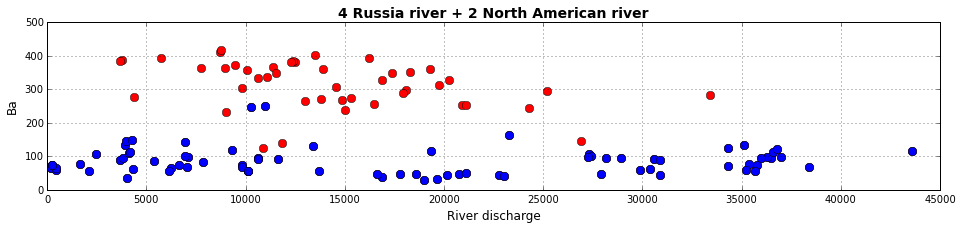

In [20]:
fig=plt.figure(figsize=(16, 3))
ax=plt.gca()
ax.plot(total_discharge, total_Ba, 'ro', markersize=8)
ax.plot(russia_discharge, russia_Ba, 'bo', markersize=8)
ax.set_ylim(0, 500); ax.set_xlim(0, 45000)
ax.set_title('4 Russia river + 2 North American river', fontsize=14, fontweight='bold')
ax.set_xlabel('River discharge', fontsize=12)
ax.set_ylabel('Ba', fontsize=12)
plt.grid()

In [21]:
corr, p = pearsonr(Lena_Ba.flat, Lena_discharge.flat)
print('Lena\n\tNumber of data points: {}\n\tCorrelation Index: {}\n\tSignificance: {}'.format(len(Lena_Ba.flat), corr, p))
corr, p = pearsonr(Ob_Ba.flat, Ob_discharge.flat)
print('Lena\n\tNumber of data points: {}\n\tCorrelation Index: {}\n\tSignificance: {}'.format(len(Ob_Ba.flat), corr, p))
corr, p = pearsonr(Kolyma_Ba.flat, Kolyma_discharge.flat)
print('Kolyma\n\tNumber of data points: {}\n\tCorrelation Index: {}\n\tSignificance: {}'.format(len(Kolyma_Ba.flat), corr, p))
# Yenisey
full_list=range(len(Yenisey_Ba.flat))
black_list=[6, 10, 11, 16]
select_list=list(set(full_list)-set(black_list))
corr, p = pearsonr(Yenisey_Ba.flat[select_list], Yenisey_discharge.flat[select_list])
print('Yenisey (4 points deleted)\n\tNumber of data points: {}\n\tCorrelation Index: {}\n\tSignificance: {}'.format(len(Yenisey_Ba.flat), corr, p))
#print('\tBlack List:\n\t\t{}'.format(np.array(Yenisey_time).flat[black_list]))
corr, p = pearsonr(Mackenzie_Ba.flat, Mackenzie_discharge.flat)
print('Mackenzie\n\tNumber of data points: {}\n\tCorrelation Index: {}\n\tSignificance: {}'.format(len(Mackenzie_Ba.flat), corr, p))
corr, p = pearsonr(Yukon_Ba.flat, Yukon_discharge.flat)
print('Yukon\n\tNumber of data points: {}\n\tCorrelation Index: {}\n\tSignificance: {}'.format(len(Yukon_Ba.flat), corr, p))

Lena
	Number of data points: 23
	Correlation Index: 0.147843708504
	Significance: 0.500815148754
Lena
	Number of data points: 23
	Correlation Index: -0.497031055481
	Significance: 0.015828688295
Kolyma
	Number of data points: 13
	Correlation Index: -0.351579389874
	Significance: 0.238798214491
Yenisey (4 points deleted)
	Number of data points: 21
	Correlation Index: -0.787079918059
	Significance: 0.000177315476943
Mackenzie
	Number of data points: 23
	Correlation Index: -0.51442035801
	Significance: 0.0120257313297
Yukon
	Number of data points: 25
	Correlation Index: -0.608993449744
	Significance: 0.00123416483049


In [22]:
coef1_Ob = np.polyfit(Ob_discharge.flat, Ob_Ba.flat, 1)
coef1_Ye = np.polyfit(Yenisey_discharge.flat[select_list], Yenisey_Ba.flat[select_list], 1)
coef1_Ma = np.polyfit(Mackenzie_discharge.flat, Mackenzie_Ba.flat, 1)
coef1_Yu = np.polyfit(Yukon_discharge.flat, Yukon_Ba.flat, 1)

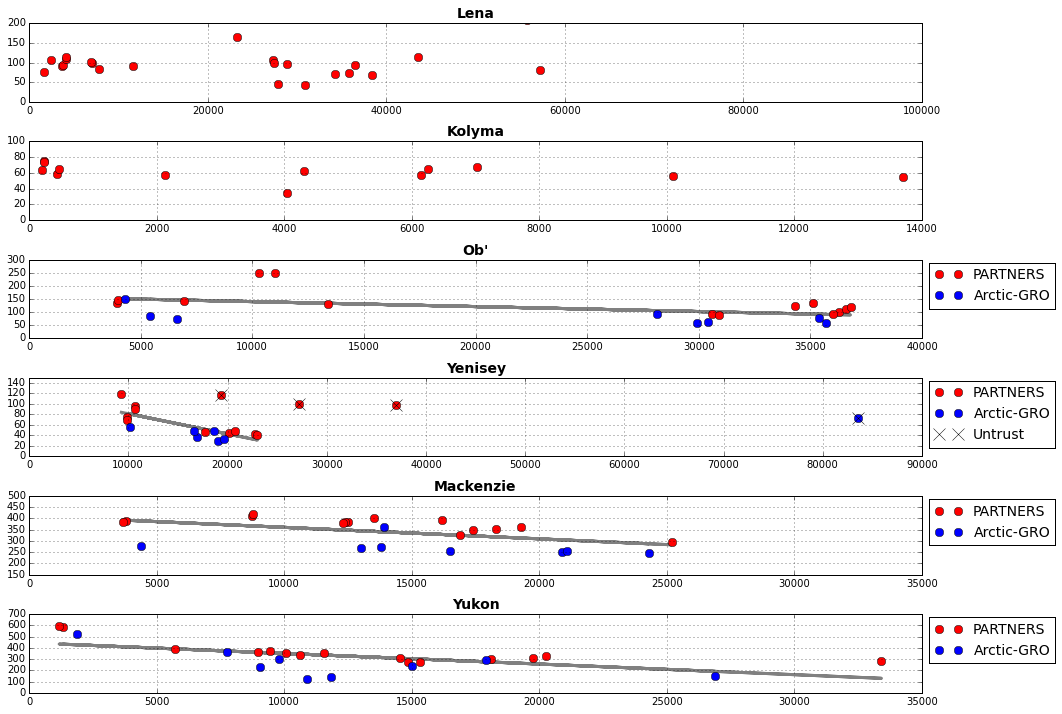

In [23]:
fig=plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace = 0.5)

ax1=plt.subplot2grid((6, 1), (0, 0), colspan=6, rowspan=1)
ax2=plt.subplot2grid((6, 1), (1, 0), colspan=6, rowspan=1)
ax3=plt.subplot2grid((6, 1), (2, 0), colspan=6, rowspan=1)
ax4=plt.subplot2grid((6, 1), (3, 0), colspan=6, rowspan=1)
ax5=plt.subplot2grid((6, 1), (4, 0), colspan=6, rowspan=1)
ax6=plt.subplot2grid((6, 1), (5, 0), colspan=6, rowspan=1)

ax1.plot(Lena_discharge.flat, Lena_Ba.flat, 'ro', markersize=8)
ax1.set_ylim(0, 200); ax1.set_xlim(0, 60000)
ax1.set_title('Lena', fontsize=14, fontweight='bold')
ax1.grid()

ax2.plot(Kolyma_discharge.flat, Kolyma_Ba.flat, 'ro', markersize=8)
ax2.set_ylim(0, 100); ax1.set_xlim(0, 100000)
ax2.set_title('Kolyma', fontsize=14, fontweight='bold')
ax2.grid()

ax3.plot(Ob_discharge.flat, Ob_discharge.flat*coef1_Ob[0]+coef1_Ob[1], color='gray', linewidth=3)
ax3.plot(Ob_discharge.flat[0:14], Ob_Ba.flat[0:14], 'ro', label='PARTNERS', markersize=8)
ax3.plot(Ob_discharge.flat[14:-1], Ob_Ba.flat[14:-1], 'bo', label='Arctic-GRO', markersize=8)
ax3.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1.05))
ax3.set_ylim(0, 300); ax.set_xlim(0, 50000)
ax3.set_title("Ob'", fontsize=14, fontweight='bold')
ax3.grid()

ax4.plot(Yenisey_discharge.flat[select_list], Yenisey_discharge.flat[select_list]*coef1_Ye[0]+coef1_Ye[1], color='gray', linewidth=3)
ax4.plot(Yenisey_discharge.flat[0:13], Yenisey_Ba.flat[0:13], 'ro', label='PARTNERS', markersize=8)
ax4.plot(Yenisey_discharge.flat[13:-1], Yenisey_Ba.flat[13:-1], 'bo', label='Arctic-GRO', markersize=8)
ax4.plot(Yenisey_discharge.flat[black_list], Yenisey_Ba.flat[black_list], 'kx', label='Untrust', markersize=12)
ax4.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1.05))
ax4.set_ylim(0, 150); ax4.set_xlim(0, 90000)
ax4.set_title('Yenisey', fontsize=14, fontweight='bold')
ax4.grid()

ax5.plot(Mackenzie_discharge.flat, Mackenzie_discharge.flat*coef1_Ma[0]+coef1_Ma[1], color='gray', linewidth=3)
ax5.plot(Mackenzie_discharge.flat[0:14], Mackenzie_Ba.flat[0:14], 'ro', label='PARTNERS', markersize=8)
ax5.plot(Mackenzie_discharge.flat[14:-1], Mackenzie_Ba.flat[14:-1], 'bo', label='Arctic-GRO', markersize=8)
ax5.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1.05))
ax5.set_ylim(150, 500);ax5.set_xlim(0, 35000)
ax5.set_title('Mackenzie', fontsize=14, fontweight='bold')
ax5.grid()

ax6.plot(Yukon_discharge.flat, Yukon_discharge.flat*coef1_Yu[0]+coef1_Yu[1], color='gray', linewidth=3)
ax6.plot(Yukon_discharge.flat[0:15], Yukon_Ba.flat[0:15], 'ro', label='PARTNERS', markersize=8)
ax6.plot(Yukon_discharge.flat[15:-1], Yukon_Ba.flat[15:-1], 'bo', label='Arctic-GRO', markersize=8)
ax6.legend(fontsize=14, loc='upper left', bbox_to_anchor=(1, 1.05))
ax6.set_ylim(0, 700); ax6.set_xlim(0, 35000)
ax6.set_title('Yukon', fontsize=14, fontweight='bold')
ax6.grid()

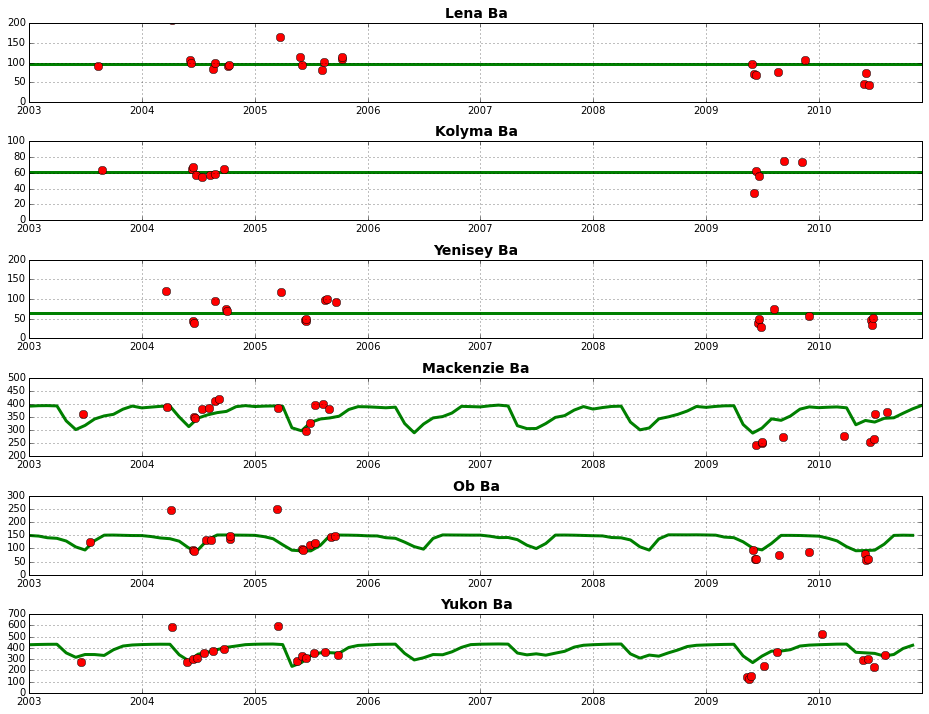

In [24]:
fig=plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace = 0.5)

ax1=plt.subplot2grid((6, 1), (0, 0), colspan=6, rowspan=1)
ax2=plt.subplot2grid((6, 1), (1, 0), colspan=6, rowspan=1)
ax3=plt.subplot2grid((6, 1), (2, 0), colspan=6, rowspan=1)
ax4=plt.subplot2grid((6, 1), (3, 0), colspan=6, rowspan=1)
ax5=plt.subplot2grid((6, 1), (4, 0), colspan=6, rowspan=1)
ax6=plt.subplot2grid((6, 1), (5, 0), colspan=6, rowspan=1)

ax1.plot(monmean, np.mean(Lena_Ba)*np.ones(len(monmean)), 'g-', linewidth=3)
ax1.plot(Lena_time, Lena_Ba.flat, 'ro', markersize=8, linewidth=2)
ax1.set_xlim(monmean[0], monmean[-1])
ax1.set_ylim(0, 200)
ax1.set_title('Lena Ba', fontsize=14, fontweight='bold')
ax1.grid()

ax2.plot(monmean, np.mean(Kolyma_Ba)*np.ones(len(monmean)), 'g-', linewidth=3)
ax2.plot(Kolyma_time, Kolyma_Ba.flat, 'ro', markersize=8, linewidth=2)
ax2.set_xlim(monmean[0], monmean[-1])
ax2.set_ylim(0, 100)
ax2.set_title('Kolyma Ba', fontsize=14, fontweight='bold')
ax2.grid()

ax3.plot(monmean, np.mean(Yenisey_Ba)*np.ones(len(monmean)), 'g-', linewidth=3)
ax3.plot(Yenisey_time, Yenisey_Ba.flat, 'ro', markersize=8, linewidth=2)
ax3.set_xlim(monmean[0], monmean[-1])
ax3.set_ylim(0, 200)
ax3.set_title('Yenisey Ba', fontsize=14, fontweight='bold')
ax3.grid()

ax4.plot(monmean, Mackenzie_discharge_monmean.flat*coef1_Ma[0] + coef1_Ma[1], linewidth=3, color='g')
ax4.plot(Mackenzie_time, Mackenzie_Ba.flat, 'ro', markersize=8, linewidth=2)
ax4.set_xlim(monmean[0], monmean[-1])
ax4.set_ylim(200, 500)
ax4.set_title('Mackenzie Ba', fontsize=14, fontweight='bold')
ax4.grid()

ax5.plot(monmean, Ob_discharge_monmean.flat*coef1_Ob[0] + coef1_Ob[1], linewidth=3, color='g')
ax5.plot(Ob_time, Ob_Ba.flat, 'ro', markersize=8, linewidth=2)
ax5.set_xlim(monmean[0], monmean[-1])
ax5.set_ylim(0, 300)
ax5.set_title('Ob Ba', fontsize=14, fontweight='bold')
ax5.grid()

ax6.plot(monmean, Yukon_discharge_monmean.flat*coef1_Yu[0]+coef1_Yu[1], linewidth=3, color='g')
ax6.plot(Yukon_time, Yukon_Ba.flat, 'ro', markersize=8, linewidth=2)
ax6.set_xlim(monmean[0], monmean[-1])
ax6.set_ylim(0, 700)
ax6.set_title('Yukon Ba', fontsize=14, fontweight='bold')
ax6.grid()

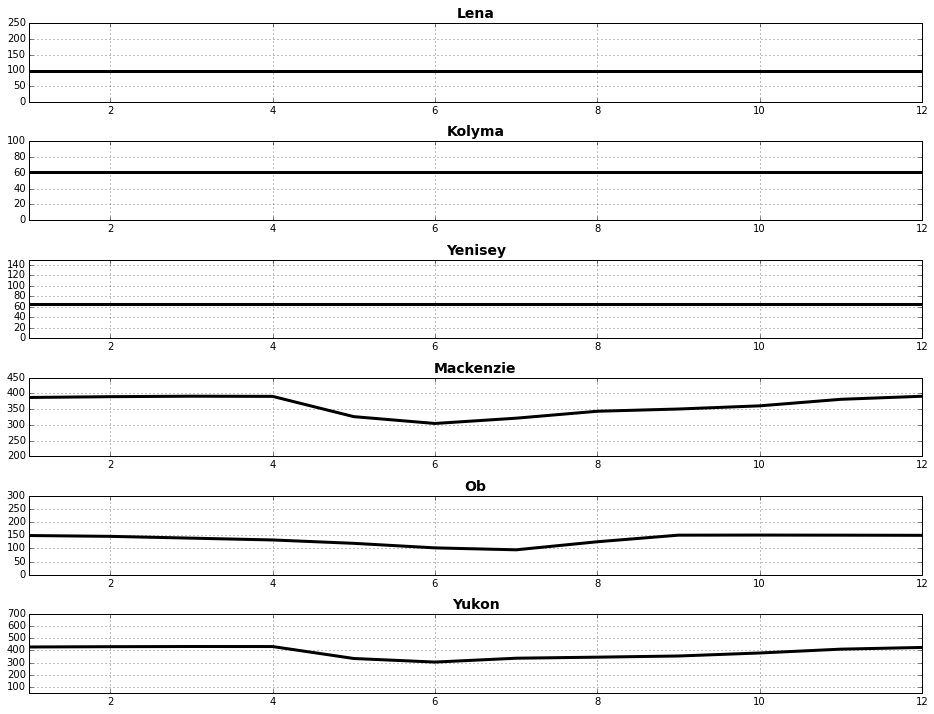

In [26]:
fig=plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace = 0.5)

Lena_forcing = np.mean(Lena_Ba)*np.ones(len(monmean))
Kolyma_forcing = np.mean(Kolyma_Ba)*np.ones(len(monmean))
Yenisey_forcing = np.mean(Yenisey_Ba)*np.ones(len(monmean))
Mackenzie_forcing = Mackenzie_discharge_monmean.flat*coef1_Ma[0] + coef1_Ma[1]
Ob_forcing = Ob_discharge_monmean.flat*coef1_Ob[0] + coef1_Ob[1]
Yukon_forcing = Yukon_discharge_monmean.flat*coef1_Yu[0]+coef1_Yu[1]

Lena_season, _ = seasonal_character(monmean, Lena_forcing)
Kolyma_season, _ = seasonal_character(monmean, Kolyma_forcing)
Yenisey_season, _ = seasonal_character(monmean, Yenisey_forcing)
Mackenzie_season, _ = seasonal_character(monmean, Mackenzie_forcing)
Ob_season, _ = seasonal_character(monmean[:-2], Ob_forcing[:-2])
Yukon_season, _ = seasonal_character(monmean[:-2], Yukon_forcing[:-2])

Lena_season, _ = seasonal_character(monmean, Lena_forcing)
Kolyma_season, _ = seasonal_character(monmean, Kolyma_forcing)
Yenisey_season, _ = seasonal_character(monmean, Yenisey_forcing)
Mackenzie_season, _ = seasonal_character(monmean, Mackenzie_forcing)
Ob_season, _ = seasonal_character(monmean[:-2], Ob_forcing[:-2])
Yukon_season, _ = seasonal_character(monmean[:-2], Yukon_forcing[:-2])

ax1=plt.subplot2grid((6, 1), (0, 0), colspan=6, rowspan=1)
ax2=plt.subplot2grid((6, 1), (1, 0), colspan=6, rowspan=1)
ax3=plt.subplot2grid((6, 1), (2, 0), colspan=6, rowspan=1)
ax4=plt.subplot2grid((6, 1), (3, 0), colspan=6, rowspan=1)
ax5=plt.subplot2grid((6, 1), (4, 0), colspan=6, rowspan=1)
ax6=plt.subplot2grid((6, 1), (5, 0), colspan=6, rowspan=1)

ax1.plot(np.arange(1, 13), Lena_season, color='k', linewidth=3)
ax1.set_xlim(1, 12); ax1.set_ylim(0, 250)
ax1.set_title('Lena', fontsize=14, fontweight='bold')
ax1.grid()

ax2.plot(np.arange(1, 13), Kolyma_season, color='k', linewidth=3)
ax2.set_xlim(1, 12); ax2.set_ylim(0, 100)
ax2.set_title('Kolyma', fontsize=14, fontweight='bold')
ax2.grid()

ax3.plot(np.arange(1, 13), Yenisey_season, color='k', linewidth=3)
ax3.set_xlim(1, 12); ax3.set_ylim(0, 150)
ax3.set_title('Yenisey', fontsize=14, fontweight='bold')
ax3.grid()

ax4.plot(np.arange(1, 13), Mackenzie_season, color='k', linewidth=3)
ax4.set_xlim(1, 12); ax4.set_ylim(200, 450)
ax4.set_title('Mackenzie', fontsize=14, fontweight='bold')
ax4.grid()

ax5.plot(np.arange(1, 13), Ob_season, color='k', linewidth=3)
ax5.set_xlim(1, 12); ax5.set_ylim(0, 300)
ax5.set_title('Ob', fontsize=14, fontweight='bold')
ax5.grid()

ax6.plot(np.arange(1, 13), Yukon_season, color='k', linewidth=3)
ax6.set_xlim(1, 12); ax6.set_ylim(50, 700)
ax6.set_title('Yukon', fontsize=14, fontweight='bold')
ax6.grid()